In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


#import SQL Alchemy dependencies/ Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

#import data dependiences 
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
#create engine to fectch data from folder named "Resources" 
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
#one can view all classes either through inspector as shown below
inspector = inspect(engine) 
inspector.get_table_names()

['measurement', 'station']

In [4]:
#to view data type in table named 'measurement'
columns = inspector.get_columns('measurement')

for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [5]:
#to view data type in table named 'station'
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
mapper = inspect(Measurement)
print(mapper)

Mapper|measurement|measurement


# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#The last measurement provided in the sql-database (hawii-measurements.csv) is 08-23,0.45,76

precipitation_analysis_1 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()

In [11]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()
last_date

[('2017-08-23')]

In [12]:
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
prev_year

datetime.date(2016, 8, 23)

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column

prec_df = pd.DataFrame(precipitation_analysis_1)
prec_df.set_index('date', inplace=True, )
prec_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


<IPython.core.display.Javascript object>


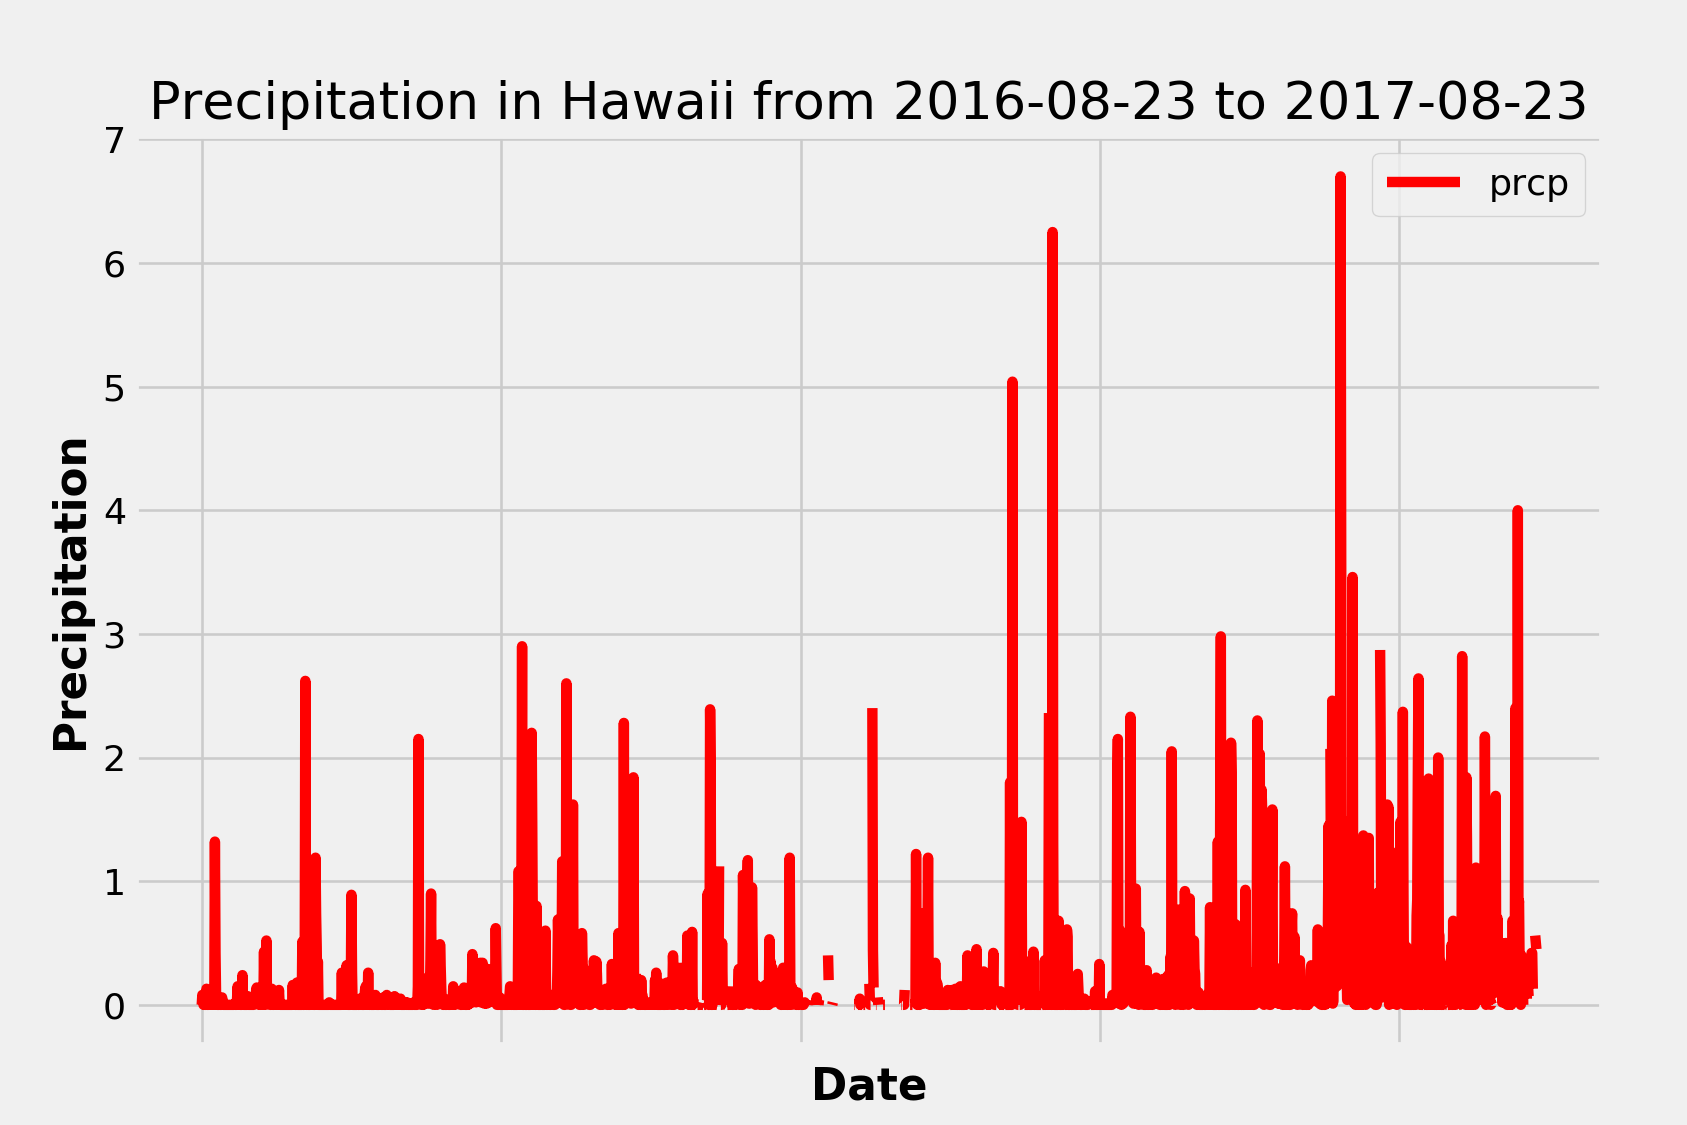

In [14]:

#plot the data#plot the 
prec_plot = prec_df.plot(figsize = (9, 6),sort_columns=True, rot=45, use_index=True, legend=True, grid=True, color='r')
plt.ylabel('Precipitation', weight='bold')
plt.xlabel('Date', weight='bold')
plt.title("Precipitation in Hawaii from 2016-08-23 to 2017-08-23")
#plt.tight_layout()
plt.show()
plt.savefig('Precipitation in Hawaii.png', bbox_inches = 'tight')

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# How many stations are available in this dataset?
  
station_num = session.query(Station.id).count()
station_num

9

In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.
most_active_station = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

most_active_station

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = most_active_station[0][0]
sel = [Measurement.station, 
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]
session.query(*sel).filter(Measurement.station == most_active_station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
waihee_tobs = session.query(Measurement.tobs).\
filter(Measurement.station == "USC00519281", Measurement.station == Station.station, Measurement.date >="2016-08-23", Measurement.date <="2017-08-23").\
all()
waihee_tobs[:5]

[(77.0), (77.0), (80.0), (80.0), (75.0)]

In [19]:
len(waihee_tobs)

352

In [20]:
print(waihee_tobs[0][0])

77.0


In [21]:

temperatures = [temp[0] for temp in waihee_tobs]
temperatures[:5]

[77.0, 77.0, 80.0, 80.0, 75.0]

<IPython.core.display.Javascript object>


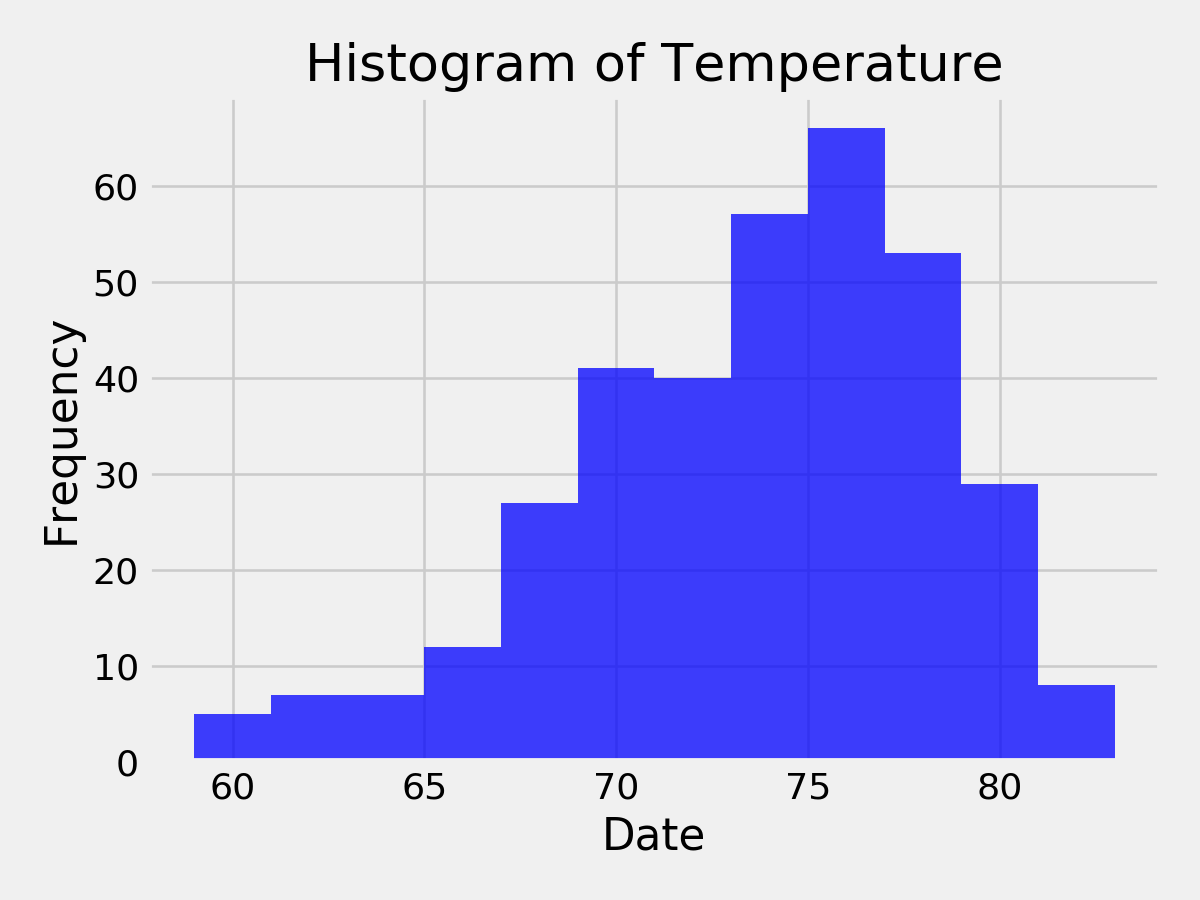

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
fig, ax = plt.subplots()
plt.hist(temperatures, bins = 12, align='mid', label="tobs", alpha=0.75,color="b")
plt.title('Last Year Temperature at Station USC00519281')
plt.xlabel('Temperature')
plt.ylabel("Frequency")
plt.title('Histogram of Temperature')
fig.tight_layout()
plt.show()
plt.savefig('Histogram of Temperature.png', dpi=fig.dpi)

In [26]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

Temp=[]
start_date='2017-08-01'
end_date='2017-08-08'
def calc_temps(start_date, end_date):
    results=session.query(func.max(Measurement.tobs).label("max_tobs"), \
                          func.min(Measurement.tobs).label("min_tobs"),\
                          func.avg(Measurement.tobs).label("avg_tobs")).\
                          filter(Measurement.date.between(start_date , end_date))  
    res = results.one()
    res
    TMAX = res.max_tobs
    TMIN= res.min_tobs
    TAVG= res.avg_tobs
    Temp.append(TMAX)
    Temp.append(TMIN)
    Temp.append(TAVG)
calc_temps(start_date, end_date)
Temp


[83.0, 72.0, 79.15625]

In [24]:
TAVG=Temp[2]
TMIN=Temp[1]
TMAX=Temp[0]


In [25]:
t_df = pd.DataFrame({'TMIN': 79.15, 'TAVG': 72, 'TMAX': 83}, index=[0])
t_df

,TMIN,TAVG,TMAX
0,79.15,72,83


<IPython.core.display.Javascript object>


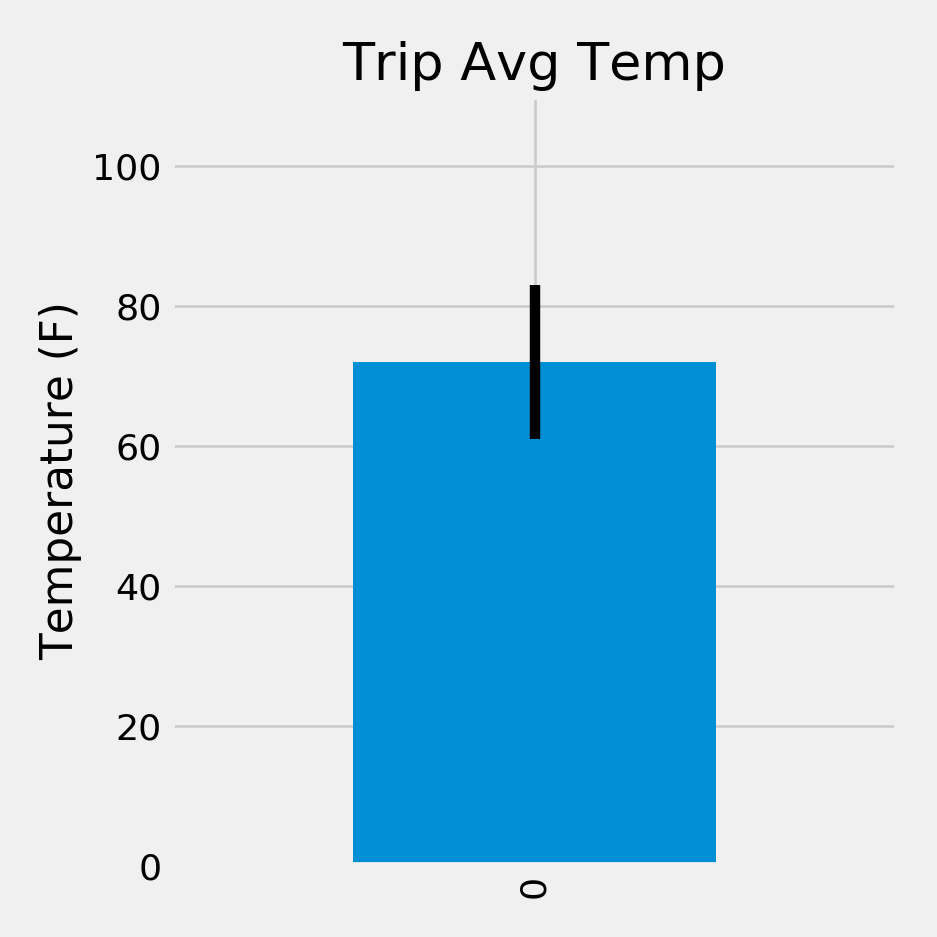

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_bar = t_df.plot(y='TAVG', yerr=TMAX-TMIN, kind='bar', figsize=(5, 5), legend=False, align= 'center')
temp_bar.set_ylabel('Temperature (F)')
temp_bar.set_title('Trip Avg Temp')
temp_bar.set_ylim(0,110)
plt.tight_layout()
plt.show()
plt.savefig('Trip Avg Temp.png')

In [37]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def find_station_prcp(start_date, end_date):
    """List of stations each containing STATION, NAME, LATITUDE, LONGITUDE, and ELEVATION for a particular date.
    
    Args:
        date (string): A date string in the format %Y-%m-%d
        
    Returns:
        STATION, NAME, LATITUDE, LONGITUDE, and ELEVATION for every station
    """
    sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
    return session.query(*sel).filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

find_station_prcp('2017-08-01', '2017-08-08')

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.7),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.32),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

In [38]:
from sqlalchemy import extract  
trip_month=8
trip_days=range(1, 8)
for i in range(1, 8):
    subquery=session.query(Measurement.date).filter(extract('month', Measurement.date)==trip_month).\
             filter(extract('day', Measurement.date)== i ).group_by(Measurement.date).order_by(Measurement.date).all()
subquery

[('2010-08-07'),
 ('2011-08-07'),
 ('2012-08-07'),
 ('2013-08-07'),
 ('2014-08-07'),
 ('2015-08-07'),
 ('2016-08-07'),
 ('2017-08-07')]

## Optional Challenge Assignment

In [39]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [47]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [48]:
dates=[]
daily_normals_Three_AVG=[]
daily_normals_TMAX=[]
daily_normals_TMIN=[]
daily_normals_TAVG=[]

trip_month=8
trip_days=range(1, 8)

def daily_normals():
    
    for i in range(1,8):
        results=session.query(Measurement.date.label("dates"), func.max(Measurement.tobs).label("max_tobs"),\
                             func.min(Measurement.tobs).label("min_tobs"),func.avg(Measurement.tobs).label("avg_tobs")).\
                             filter(extract('month', Measurement.date)==trip_month).\
                             filter(extract('day', Measurement.date)== i ).group_by(Measurement.date).order_by(Measurement.date)
        results
        for res in results.all():
             print( res)
        
        res
        TMAX = res.max_tobs
        TMIN= res.min_tobs
        TAVG= res.avg_tobs
        Date= res.dates
        
        data = [TMAX, TMIN, TAVG]
        

        dates.append(Date)
        
        daily_normals_TMAX.append(TMAX)
        daily_normals_TMIN.append(TMIN)
        daily_normals_TAVG.append(TAVG)
        
daily_normals()

('2010-08-01', 77.0, 71.0, 73.42857142857143)
('2011-08-01', 78.0, 67.0, 73.375)
('2012-08-01', 79.0, 71.0, 75.85714285714286)
('2013-08-01', 79.0, 75.0, 76.83333333333333)
('2014-08-01', 83.0, 73.0, 77.42857142857143)
('2015-08-01', 79.0, 73.0, 77.4)
('2016-08-01', 78.0, 73.0, 76.16666666666667)
('2017-08-01', 77.0, 72.0, 74.5)
('2010-08-02', 76.0, 70.0, 73.22222222222223)
('2011-08-02', 77.0, 70.0, 73.625)
('2012-08-02', 78.0, 68.0, 73.5)
('2013-08-02', 78.0, 70.0, 74.57142857142857)
('2014-08-02', 81.0, 73.0, 77.71428571428571)
('2015-08-02', 84.0, 76.0, 80.0)
('2016-08-02', 80.0, 72.0, 76.57142857142857)
('2017-08-02', 83.0, 73.0, 79.0)
('2010-08-03', 77.0, 70.0, 73.11111111111111)
('2011-08-03', 78.0, 71.0, 75.25)
('2012-08-03', 78.0, 72.0, 74.57142857142857)
('2013-08-03', 79.0, 72.0, 76.66666666666667)
('2014-08-03', 83.0, 74.0, 78.33333333333333)
('2015-08-03', 85.0, 75.0, 80.0)
('2016-08-03', 82.0, 74.0, 78.42857142857143)
('2017-08-03', 81.0, 76.0, 79.0)
('2010-08-04', 77.0, 

In [49]:

trip_start_date = '2018-07-01'
trip_end_date = '2018-07-08'

In [50]:
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
trip_range = pd.date_range(trip_start_date, trip_end_date)
trip_range

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08'],
              dtype='datetime64[ns]', freq='D')

In [51]:
# Strip off the year and save a list of %m-%d strings
trip_dates_md = []
for date in trip_range:
    trip_dates_md.append(date.strftime('%m-%d'))
trip_dates_md

['07-01', '07-02', '07-03', '07-04', '07-05', '07-06', '07-07', '07-08']

In [52]:

Daily_normals_df = pd.DataFrame({'Date': dates, 'TMAX': daily_normals_TMAX, 'TMIN': daily_normals_TMIN,'TAVG': daily_normals_TAVG,})
Daily_normals_df.set_index('Date', inplace=True, )
Daily_normals_df

,TMAX,TMIN,TAVG
Date,,,
2017-08-01,77.0,72.0,74.5
2017-08-02,83.0,73.0,79.0
2017-08-03,81.0,76.0,79.0
2017-08-04,82.0,77.0,80.0
2017-08-05,82.0,77.0,80.0
2017-08-06,83.0,79.0,81.4
2017-08-07,83.0,78.0,80.5


<IPython.core.display.Javascript object>


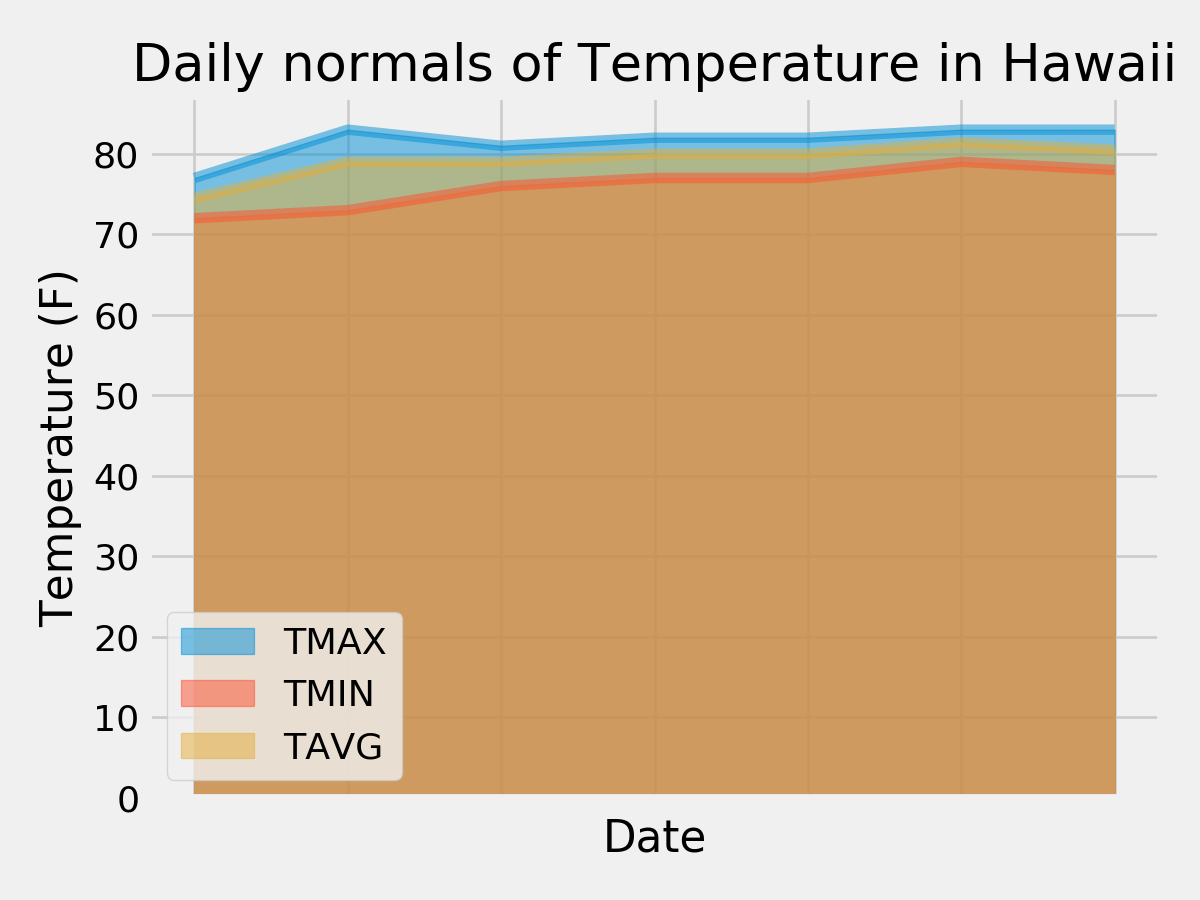

Text(0.5,84.125,'Date')

In [53]:
Daily_normals_df.plot(kind = 'area', stacked=False, rot=45, legend= 'best',title='Daily normals of Temperature in Hawaii')
plt.ylabel("Temperature (F)")
plt.tight_layout()
ax.set_xlabel('Date')
#Daily_normals_plot.set_xlabel('trip_dates_md')